## Example 1: Evaluation of  Weizsacker-Williams gluon distribution functions

In this example, we utilize our toolbox to calculate the Wilson Line $U$ for many different target configurations, which we then use to calculate the distribution of linearly polarized/unpolarized gluons as in [1] (numerically) or [2] (analytically). We compare our results to those from [1] at the end, and see good agreement.

### References

[1] Dumitru, A., Lappi, T., & Skokov, V. (2015). The distribution of linearly polarized gluons and elliptic azimuthal anisotropy in DIS dijet production at high energy. https://doi.org/10.1103/PhysRevLett.115.252301

[2] Metz, A., & Zhou, J. (2011). Distribution of linearly polarized gluons inside a large nucleus. https://doi.org/10.1103/PhysRevD.84.051503

In [1]:
# If you haven't formally installed the toolbox, you will need
# this line to get proper access to the functions
import sys
sys.path.append('../')

# Import our functions
import cgc

# To make the evaluation responsive and more user friendly
import progressbar

# Import numpy and matplotlib for plotting/other utility
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.fft import fft2

# Make our plots nice and large
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 12

We first generate $M$ different targets (nuclei) and calculate the Wilson Line $V$ for each

In [2]:
M = 6 # Number of configurations  
N = 256  # Lattice size
L = 32 # S_\perp = L^2 is the area of the target
delta = L/N 
mu = 1 # defines the units in the calculation

# Collecting and storing configurations; here the fundamental Wilson line in x space are stored
V_list = np.zeros([M, N, N, 3, 3], dtype=np.complex128) # The wilson line is a 3x3 matrix at each lattice point

# This step may take a while, so we'll use a progress bar to see how far along we are
# We'll use this several times later on as well
progressBar = progressbar.ProgressBar(max_value=M)

# Generate M targets and calculate their Wilson lines
for i in range(M):
    progressBar.update(i)
    nucleus = cgc.Nucleus(3, N, delta, mu, M=0.1, Ny=100)
    V_list[i] = nucleus.wilsonLine()
progressBar.update(M)

100% (6 of 6) |##########################| Elapsed Time: 0:03:58 ETA:  00:00:00

Next, we calculate the gauge field $A$, the linearly polarized distribution $G$ and the unpolarized distribution $h$.

Analytically, we have:

$$ A^i(\vec x_T)  = \frac{1}{i g} U^\dagger(\vec x_T) \partial_i U(\vec x_T) \hspace{2cm} \text{[Dumitru et al. 2015, Eq. 9]}$$

These take the numerical form:

$$ A^0_{i,j} = \frac{i}{2} \left( V^\dagger_{i,j} \frac{(V_{i+1,j} - V_{i-1,j})}{2} -  \frac{(V^\dagger_{i+1,j} - V^\dagger_{i-1,j})}{2} V_{i,j} \right)$$

$$ A^1_{i,j} = \frac{i}{2} \left( V^\dagger_{i,j} \frac{(V_{i,j+1} - V_{i,j-1})}{2} -  \frac{(V^\dagger_{i,j+1} - V^\dagger_{i,j-1})}{2} V_{i,j} \right)$$

Now our distribution functions are:

$$ G_{ij} = \text{tr}\left\{ A^0_{ij}(\vec k) A^0_{ij}(\vec k)^\dagger \right\} + \text{tr}\left\{ A^1_{ij}(\vec k) A^1_{ij}(\vec k)^\dagger \right\} $$

$$ h_{ij} = -G_{ij} + \frac{2}{k^2} \sum_{a = 0,1} \sum_{b = 0,1} k_a k_b \text{tr}\{ A^a_{ij}(\vec k) A^b_{ij}(\vec k)^\dagger \}$$

or

$$ h_{ij} = -\sum_{a = 0,1} \sum_{b = 0,1} \delta^{ab} \text{tr} \left\{ A^a_{ij}(\vec k) A^b_{ij}(\vec k)^\dagger \right\} + \frac{2}{k^2} \sum_{a = 0,1} \sum_{b = 0,1} k_a k_b \text{tr} \left\{ A^a_{ij}(\vec k) A^b_{ij}(\vec k)^\dagger \right\}$$

$$ h_{ij} = \sum_{a = 0,1} \sum_{b = 0,1} \left( \frac{2 k_a k_b}{k^2} - \delta^{ab} \right) \text{tr}\left \{ A^a_{ij}(\vec k) A^b_{ij}(\vec k)^\dagger \right \} $$

where $A^a_{ij}(\vec k)$ is the gauge field in fourier space at the lattice point $(i,j)$.

In [3]:
# Note that these values are specific to each configuration (of which we have M)
# We will keep each configuration separate, and at the end will bootstrap to get
# a statistically significant result
G = np.zeros([N, N, M], dtype=np.complex128)
h = np.zeros([N, N, M], dtype=np.complex128)

progressBar = progressbar.ProgressBar(max_value=len(V_list)*N)

for i in range(len(V_list)):
    progressBar.update(i)

    # The gauge field; this is specific to each configuration
    A = np.zeros([N, N, 2, 3, 3], dtype=np.complex128)

    # It helps to calculate the conjugate transpose of the wilson line
    # before we begin (see the above equation)
    V = V_list[i]
    Vdag = np.conjugate(np.swapaxes(V, -2, -1))

    # Calculate the gauge field at each point on the lattice
    for y in range(N):
        for x in range(N):
            # The '@' symbol stands for matrix multiplication
            # The '%N' in the indexing enforces periodic boundary conditions
            A[y,x,0] = 1.j * (Vdag[y,x] @ (V[(y+1)%N,x] - V[(y-1)%N,x]) - (Vdag[(y+1)%N,x] - Vdag[(y-1)%N,x]) @ V[y,x] ) / 4
            A[y,x,1] = 1.j * (Vdag[y,x] @ (V[y,(x+1)%N] - V[y,(x-1)%N]) - (Vdag[y,(x+1)%N] - Vdag[y,(x-1)%N]) @ V[y,x] ) / 4  

    # Take the fourier transform of the gauge field
    AM = fft2(A, axes=(0, 1), norm=None, workers=-1)  

    for y in range(N):
        progressBar.update(i*N + y)
        for x in range(N):
            # Calculate the momentum at each point in fourier space
            kx = 2*np.sin(np.pi/N * y)/delta * np.sign(np.sin(2*np.pi/N * y))
            ky = 2*np.sin(np.pi/N * x)/delta * np.sign(np.sin(2*np.pi/N * x))
            k2 = kx**2 + ky**2 + 1e-16 # This second part is to avoid divide by zero errors

            # Calculate the conjugate-transpose of the gauge field in fourier space
            AMDag = np.conjugate(np.swapaxes(AM, -2, -1))
            #AM0_conj = np.transpose(np.conjugate(AM[k,l,0]))
            #AM1_conj = np.transpose(np.conjugate(AM[k,l,1]))

            # Precompute these traces since they are used more than once
            diagTrace1 = np.trace(AM[y,x,0] @ AMDag[y,x,0])
            diagTrace2 = np.trace(AM[y,x,1] @ AMDag[y,x,1])
            G[y,x,i] = diagTrace1 + diagTrace2
            h[y,x,i] = -G[y,x,i]
            h[y,x,i] += 2*kx*kx/k2 * diagTrace1
            h[y,x,i] += 2*ky*ky/k2 * diagTrace2
            h[y,x,i] += 2*kx*ky/k2 * np.trace(AM[y,x,0] @ AMDag[y,x,1])
            h[y,x,i] += 2*kx*ky/k2 * np.trace(AM[y,x,1] @ AMDag[y,x,0])

    G[:,:,i] = 2 * G[:,:,i] / (N*N*(2*np.pi)**4) # the final expression is xG alpha_s/S_\perp
    h[:,:,i] = 2 * h[:,:,i] / (N*N*(2*np.pi)**4) # the final expression is xh alpha_s/S_\perp

 99% (1535 of 1536) |################### | Elapsed Time: 0:24:03 ETA:   0:00:00

Now that we have expressions for both $G$ and $h$, we want to flatten our lattice representation and bin by the mangitude of the momentum at each point.

In [4]:
# We will have a total of N/2 bins for each configuration
numBins = int(N/2)
# This is the bin size we will be using for N/2 bins
# This means our maximum momentum is 2/delta
binSize = 2/delta / numBins

# (Keep the configurations separate still)
G_b = np.zeros([numBins,M], dtype='float')
h_b = np.zeros([numBins,M], dtype='float')

# We don't really need a progress bar here since this one is very fast
for m in range(M):
    
    # We want to calculate the magnitude of the momentum at each point on the lattice
    # Since we have a symmetric lattice, the value of the momenta components will also
    # be symmetric, and we can just calculate one component, square it, and do an
    # outer addition (outer product but adding instead of multiplying)
    kComSqr = (2/delta * np.sin(np.pi/N * np.arange(N)))**2
    kMag = np.sqrt(np.add.outer(kComSqr, kComSqr))
    
    # Now we grab all of the lattice points that exist within each bin, which
    # essentially means we are creating thin rings centered on the lattice
    for i in range(numBins):
        # The complex boolean statement grabs the indices of the points
        # whose momentum is within this bin
        # This means we get a (flattened) array out of values at points that satisfy the condition
        # And we divide out the number of points in each bin
        numPointsInBin = len(G[:,:,m][(kMag < binSize * (i+1)) & (kMag >= binSize * i)])

        h_b[i,m] = np.sum(np.real(h[:,:,m][(kMag < binSize * (i+1)) & (kMag >= binSize * i)])) / numPointsInBin
        G_b[i,m] = np.sum(np.real(G[:,:,m][(kMag < binSize * (i+1)) & (kMag >= binSize * i)])) / numPointsInBin

Finally, we bootstrap our separate configurations so as to get a statistically averaged result with error estimation. This means we randomly select $M/2$ configurations with replacement, and calculate the mean/standard deviation from this resample.

In [5]:
#bootstrap for error estimation
Nbstrp = int(M/2)

# Randomly select Nbstrp configurations (with replacement)
resampleSelection = np.random.randint(M, size=(Nbstrp))

G_resample = G_b[:,resampleSelection]
h_resample = h_b[:,resampleSelection]

# Now take our statistics on this resample
G_final = np.mean(G_resample, axis=1)
h_final = np.mean(h_resample, axis=1)

G_error = np.std(G_resample, axis=1)
h_error = np.std(h_resample, axis=1)

# And the final values of momentum that we are plotting against
# Adding half the bin size makes it the center of each bin
kArr = (np.arange(N/2) + binSize/2) * binSize

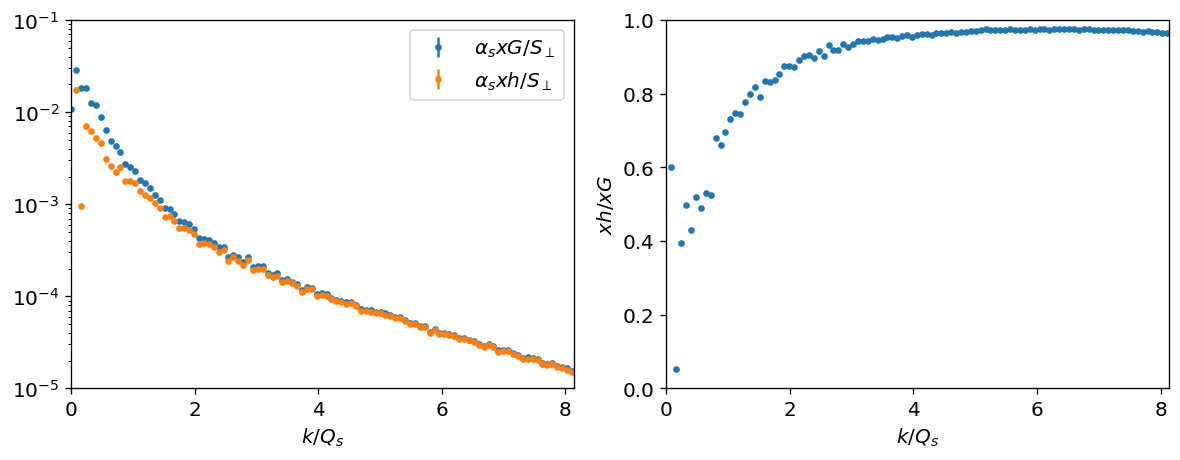

In [6]:
# Rescale our momentum by the saturation momentum Qs
muOverQs = 1.574 # as found in ScatteringMatrix_and_Qs

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# On the left: distributions of linearly polarized and unpolarized gluons
ax[0].errorbar(kArr/muOverQs, G_final, yerr=G_error, fmt='.', label=r'$\alpha_s xG/S_\perp$')
ax[0].errorbar(kArr/muOverQs, h_final, yerr=h_error, fmt='.', label=r'$\alpha_s xh/S_\perp$')

# Rescale the y axis to make the plot look nicer
ax[0].set_yscale('log')
ax[0].set_xlim([0, 0.8*2/delta/muOverQs])
ax[0].set_ylim([1e-5,1e-1])

ax[0].set_xlabel(r'$k/Q_s$')
ax[0].legend()

# On the right: ratio of the linearly polarized to unpolarized gluons
ax[1].plot(kArr/muOverQs, h_final/G_final, '.', label=r'$xh/xG')
ax[1].set_xlim([0, 0.8*2/delta/muOverQs])
ax[1].set_ylim([0, 1])
ax[1].set_xlabel(r'$k/Q_s$')
ax[1].set_ylabel(r'$xh/xG$')

fig.tight_layout()
plt.show()

Compare to Fig. 1 from [1]:

![Dumitru 2015 Fig. 1](Dumitru_2015_Fig1.png)
